## Custom dataset

In [1]:
import os
import pandas as pd
import numpy as np
import os
import json
import re
from nltk.tokenize import sent_tokenize, word_tokenize
from torch.utils.data import DataLoader
from datasets import Dataset, Features, ClassLabel, Value
import torch
import torch.nn as nn
import transformers
import glob
from sklearn.model_selection import train_test_split
import datetime 
import warnings
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from transformers import DistilBertForTokenClassification, AdamW, DataCollatorForTokenClassification, get_scheduler, BertTokenizer, AutoTokenizer
import evaluate
warnings.filterwarnings('ignore')

/Users/Iana_Kasimova/bert_ner/.venv/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Prepare data

We have text in json files, we can reach text by using id of document from csv file

In csv we can see labels, separated '|' from the document 

In [18]:
model_checkpoint = "bert-base-cased"
train_path = "../../data/coleridgeinitiative-show-us-the-data/train/"
test_path = "../../data/coleridgeinitiative-show-us-the-data/test/"

tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

df = pd.read_csv("../../data/coleridgeinitiative-show-us-the-data/train.csv")

df = df.groupby(['Id']).agg(label_count=('cleaned_label', 'count'),
label = ('cleaned_label', '|'.join)).reset_index()
df.head()

,Id,label_count,label
0,0007f880-0a9b-492d-9a58-76eb0b0e0bd7,1,program for the international assessment of ad...
1,0008656f-0ba2-4632-8602-3017b44c2e90,1,trends in international mathematics and scienc...
2,000e04d6-d6ef-442f-b070-4309493221ba,1,agricultural resources management survey
3,000efc17-13d8-433d-8f62-a3932fe4f3b8,2,adni|alzheimer s disease neuroimaging initiati...
4,0010357a-6365-4e5f-b982-582e6d32c3ee,1,genome sequence of covid 19


In [19]:
def filter_dataset(df, path):
    result = df.copy()
    for i, id in enumerate(df.Id):
        location = f"{path}{id}.json"
        if not os.path.exists(location):
            result.drop(i, inplace=True)
    return result

In [20]:
test_df = filter_dataset(df, test_path)
train_df = filter_dataset(df, train_path)

In [21]:
test_df.head()

,Id,label_count,label
1826,2100032a-7c33-4bff-97ef-690822c43466,2,adni|alzheimer s disease neuroimaging initiati...
2624,2f392438-e215-4169-bebf-21ac4ff253e1,1,trends in international mathematics and scienc...
3499,3f316b38-1a24-45a9-8d8c-4e05a42257c6,2,slosh model|noaa storm surge inundation
7937,8e6996b4-ca08-4c0b-bed2-aaf07a4c6a60,1,rural urban continuum codes


In [22]:
# gather all texts from json file for one ID from read_all_json() file
def data_joining(all_texts):
    data_length = len(all_texts)

    temp = [all_texts[i]['text'] for i in range(data_length)]
    temp = '. '.join(temp)

    return temp

def read_all_json(df, path):
    text_data = []
    for i, rec_id in tqdm(enumerate(df.Id), total=df.shape[0]):
        location = f"{path}{rec_id}.json"
        if os.path.exists(location):
            
            with open(location, 'r') as f:
                text_dict = {"id": rec_id, "text": data_joining(json.load(f)), "label": df.label[i]}
                text_data.append(text_dict)
    print("All files were read") 

    return text_data 

def read_json(id, path):
    location = f"{path}{id}.json"
    if os.path.exists(location):
        with open(location, 'r') as f:
            return data_joining(json.load(f))

In [23]:
def clean_text(txt):
    return re.sub('[^A-Za-z0-9]+', ' ', str(txt).lower())

def make_shorter_sentence(sentence, max_length):
    sent_tokenized = sent_tokenize(sentence)

    final_sentences = []

    for tok_sent in sent_tokenized:
        tok_sent_clean = clean_text(tok_sent)
        tok_sent_clean = tok_sent_clean.replace(".", "").rstrip()

        tok_sent = tok_sent_clean.split(" ")

        while len(tok_sent) > max_length:
            final_sentences.append(" ".join(tok_sent[0:max_length]))
            tok_sent = tok_sent[max_length:]
    
        final_sentences.append(" ".join(tok_sent))

    return final_sentences



## Labeling
BIO tagging 

## Iterable 

In [24]:
 # get sentence, divide on a smaller sentence if it needs, and labeled each sentence by BIO tagging
#B-0
#I-1
#O-2
# For each sentence we look does it contain the labels or not, if sentence very long we separate it on a small sentences 

def convert_to_labels_iter(tokenizer, text, labels, max_length):
    tok_sent = make_shorter_sentence(text, max_length)
    items = []
    for sent in tok_sent:
        # here we can have more tokens than we have words in sentence
        # padding=False by default  
        tokenized_inputs = tokenizer([sent], add_special_tokens = True, truncation=True, is_split_into_words=True)
        item = {k:torch.tensor(v) for k, v in tokenized_inputs.items()}
        word_ids = tokenized_inputs["input_ids"]
        s = np.array([2] * len(word_ids))
        # set [CLS] and [SEP] tokens = -100
        s[0] = -100
        s[len(word_ids) - 1] = -100
        for label in labels:
            if label in sent:
                # here we can have more tokens than we have words in sentence
                labeled_inputs = tokenizer([label], add_special_tokens = False, truncation=True, is_split_into_words=True)
                label_ids = labeled_inputs["input_ids"]
                for idx in range(len(word_ids)):
                    if word_ids[idx:idx + len(label_ids)] == label_ids:
                        s[idx] = 0
                        if len(label_ids) > 1:
                            s[idx+1: idx + len(label_ids)] = 1
        item["labels"] = torch.tensor(s)
        items.append(item)
    return items                

In [25]:
class CustomIterableDataset(torch.utils.data.IterableDataset):
    # encodings it is our tokenizer
    def __init__(self, ids, labels, encodings, convert_to_labels, read_json, path, max_length):
        self.encodings = encodings
        self.ids = ids
        self.labels = labels
        self.max_length = max_length
        self.path = path
        self.reader = read_json
        self.converter = convert_to_labels

    # provide dictionary with attention_mask, labels and input_ids
    def __iter__(self):
        iter_items = []
        for id, labels in zip(self.ids, self.labels):
        #read from the disc by id
            text = self.reader(id, self.path)
            items = self.converter(self.encodings, text, labels.split("|"), self.max_length)
            iter_items.extend(items)
        return iter(iter_items) 

In [26]:
def postprocess(predictions, labels, label_names):
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [[label_names[p] for p, l in zip(prediction, label) if l != -100] for prediction, label in zip(predictions, labels)]
    return true_labels, true_predictions

In [27]:

train_df_short = train_df.head(2)
max_length=128

metric = evaluate.load("seqeval")

tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")
# fill -100 tensors till the max length in a batch
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

train_dataset = CustomIterableDataset(train_df_short.Id.values, train_df_short.label.values, tokenizer, convert_to_labels_iter, read_json, train_path, max_length)
test_dataset = CustomIterableDataset(test_df.Id.values, test_df.label.values, tokenizer, convert_to_labels_iter, read_json, test_path, max_length)


train_loader = DataLoader(train_dataset, collate_fn = data_collator,  batch_size=16)
test_loader = DataLoader(test_dataset, collate_fn = data_collator,  batch_size=16)

labels_names = ['B', 'I', 'O']
epoch_num= 2

model = DistilBertForTokenClassification.from_pretrained('distilbert-base-uncased', num_labels=len(labels_names))
optim = AdamW(model.parameters(), lr=5e-5)

model.to(device)

losses = []


for epoch in range(epoch_num):
    model.train()
    for batch in tqdm(train_loader):
        optim.zero_grad()
        outputs = model(**batch)
        loss = outputs[0]
        losses.append(loss)
        loss.backward()
        optim.step()

    model.eval()
    for batch in test_loader:
        with torch.no_grad():
            outputs = model(**batch)

        predictions = outputs.logits.argmax(dim=-1)
        labels = batch["labels"]    
        true_predictions, true_labels = postprocess(predictions, labels, labels_names)
        metric.add_batch(predictions=true_predictions, references=true_labels)
    results = metric.compute()    
    print(
        f"epoch {epoch}:",
        {
            key: results[f"overall_{key}"]
            for key in ["precision", "recall", "f1", "accuracy"]
        },
    )





Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForTokenClassification: ['vocab_transform.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN t

epoch 0: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9988370863727667}


27it [01:15,  2.81s/it]


epoch 1: {'precision': 0.0, 'recall': 0.0, 'f1': 0.0, 'accuracy': 0.9988370863727667}


In [37]:
losses_np = [item.detach().numpy().item() for item in losses]

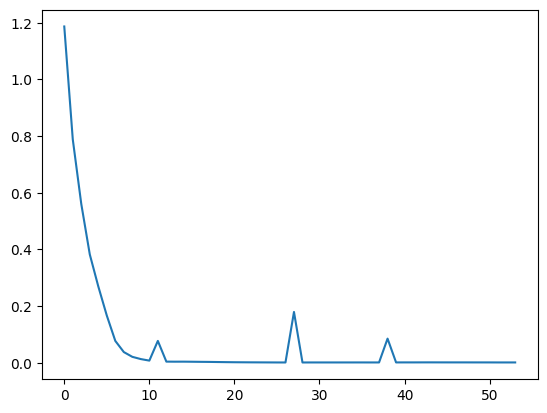

In [50]:
plt.plot(losses_np)